In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
SEED = 42

In [3]:
import tensorflow.keras

In [4]:
train_df = pd.read_csv("dataset/train.csv")
test_df = pd.read_csv("dataset/test.csv")

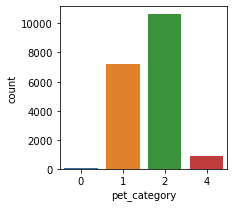

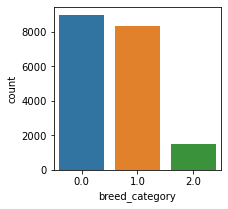

In [5]:
plt.figure(figsize=(3,3))
sns.countplot(train_df['pet_category'])

plt.figure(figsize=(3,3))
sns.countplot(train_df['breed_category'])

In [6]:
train_df['pet_category'].replace(4,value=3,inplace=True)

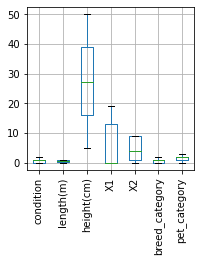

In [7]:
train_df.boxplot(figsize=(3,3),rot=90)

In [8]:
train_df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2.0,3
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1


In [9]:
train_df['condition'].fillna(float(int(train_df['condition'].mode())),inplace=True)
test_df['condition'].fillna(float(int(test_df['condition'].mode())),inplace=True)

In [10]:
x = train_df.drop(columns=['pet_id','issue_date','listing_date',"breed_category",'pet_category'])
y = train_df[['breed_category','pet_category']]
x_test = test_df.drop(columns=['pet_id','issue_date','listing_date'])

In [11]:
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,LabelEncoder

In [12]:
mm = MinMaxScaler()
le = LabelEncoder()
x[['color_type']] = le.fit_transform(x['color_type'])

In [13]:
x = mm.fit_transform(x)

In [14]:
x_test[['color_type']] = le.transform(x_test['color_type'])
x_test = mm.transform(x_test)

In [15]:
from tensorflow.keras.utils import to_categorical

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2,random_state=SEED)

In [18]:
y_train_1 = y_train.iloc[:,0].values
y_train_2 = y_train.iloc[:,1].values
y_val_1 = y_val.iloc[:,0].values
y_val_2 = y_val.iloc[:,1].values

In [19]:
y_train_1 = y_train_1.astype('float64')
y_train_2 = y_train_2.astype('float64')
y_val_1 = y_val_1.astype('float64')
y_val_2 = y_val_2.astype('float64')

In [20]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense ,Dropout,Input
from tensorflow.keras.optimizers import Adam
from livelossplot import PlotLossesKeras

In [34]:
input_layer = Input(shape=x_train.shape[1],)
x = Dense(32,activation='relu',kernel_initializer='uniform')(input_layer)
x = Dropout(0.25)(x)
x = Dense(128,activation='relu',kernel_initializer='uniform')(x)
x = Dense(128,activation='relu',kernel_initializer='uniform')(x)
x = Dropout(0.4)(x)
bottle_neck = Dense(8,activation='relu',kernel_initializer='uniform')(x)

out_1 = Dense(3,activation='softmax',name='breed')(bottle_neck)
out_2 = Dense(4,activation='softmax',name='pet')(bottle_neck)

model = Model(inputs=input_layer,outputs=[out_1,out_2])
model.compile(optimizer=Adam(lr=0.00005),
             loss = {'breed':'sparse_categorical_crossentropy','pet':'sparse_categorical_crossentropy'},
             metrics = {'breed':'accuracy','pet':'accuracy'})

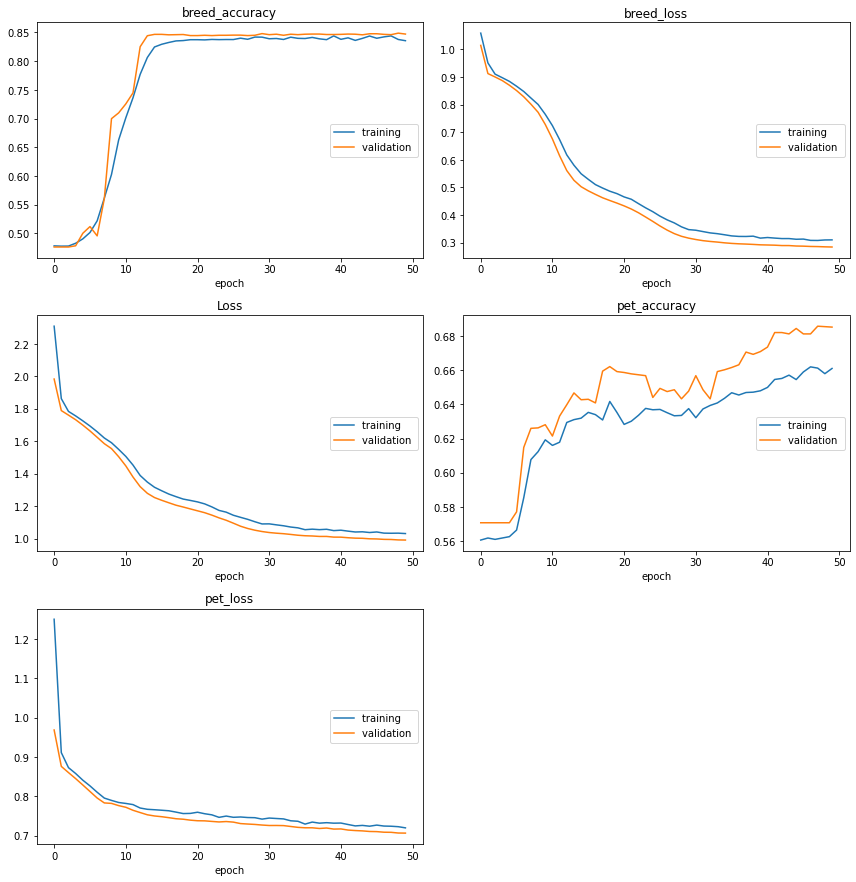

breed_accuracy
	training         	 (min:    0.478, max:    0.844, cur:    0.836)
	validation       	 (min:    0.476, max:    0.849, cur:    0.847)
breed_loss
	training         	 (min:    0.308, max:    1.059, cur:    0.310)
	validation       	 (min:    0.285, max:    1.014, cur:    0.285)
Loss
	training         	 (min:    1.030, max:    2.308, cur:    1.030)
	validation       	 (min:    0.990, max:    1.983, cur:    0.990)
pet_accuracy
	training         	 (min:    0.561, max:    0.662, cur:    0.661)
	validation       	 (min:    0.571, max:    0.686, cur:    0.685)
pet_loss
	training         	 (min:    0.720, max:    1.250, cur:    0.720)
	validation       	 (min:    0.707, max:    0.968, cur:    0.707)
15067/15067 [==============================] - 3s 168us/sample - loss: 1.0305 - breed_loss: 0.3104 - pet_loss: 0.7200 - breed_accuracy: 0.8355 - pet_accuracy: 0.6610 - val_loss: 0.9904 - val_breed_loss: 0.2846 - val_pet_loss: 0.7067 - val_breed_accuracy: 0.8471 - val_pet_accuracy: 0.685

In [35]:
h = model.fit(x_train,[y_train_1,y_train_2],
                validation_data=(x_val,[y_val_1,y_val_2]),
                epochs=50,
                callbacks=[PlotLossesKeras()])

In [41]:
y_pred_1,y_pred_2 = model.predict(x_test)
y_pred_1 = [np.argmax(i) for i in y_pred_1]
y_pred_2 = [np.argmax(i) for i in y_pred_2]

In [42]:
y_pred_2 = pd.DataFrame(y_pred_2)
y_pred_2.replace(3,value=4)
y_pred_2 = np.asarray(y_pred_2)
y_pred_2 = np.squeeze(y_pred_2)

In [43]:
sub = pd.DataFrame({'pet_id':test_df.pet_id,'breed_category':y_pred_1,'pet_category':y_pred_2})

In [44]:
sub.to_csv("Submission.csv",index=False)

In [40]:
model.save('model.h5')